In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [15]:
train_df = pd.read_csv('Train.csv')
train_df.set_index(['ID'],inplace=True)
train_df['Datetime'] = pd.to_datetime(train_df['Datetime'])

In [16]:
train_df.iloc[-5:,:]

,Datetime,Count
ID,,
18283,2014-09-25 19:00:00,868
18284,2014-09-25 20:00:00,732
18285,2014-09-25 21:00:00,702
18286,2014-09-25 22:00:00,580
18287,2014-09-25 23:00:00,534


In [62]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
train_df['Count scaled'] = scaler.fit_transform(train_df['Count'][:,np.newaxis])
train_df.head(-5)

,Datetime,Count,Count scaled
ID,,,
0,2012-08-25 00:00:00,8,0.004831
1,2012-08-25 01:00:00,2,0.000000
2,2012-08-25 02:00:00,6,0.003221
3,2012-08-25 03:00:00,2,0.000000
4,2012-08-25 04:00:00,2,0.000000
...,...,...,...
18278,2014-09-25 14:00:00,616,0.494364
18279,2014-09-25 15:00:00,686,0.550725
18280,2014-09-25 16:00:00,654,0.524960


In [20]:
test_df = pd.read_csv('Test.csv',index_col=['ID'])
test_df['Datetime'] = pd.to_datetime(test_df['Datetime'])
test_df.head()

,Datetime
ID,
18288,2014-09-26 00:00:00
18289,2014-09-26 01:00:00
18290,2014-09-26 02:00:00
18291,2014-09-26 03:00:00
18292,2014-09-26 04:00:00


In [21]:
train_df.head(30)

,Datetime,Count
ID,,
0,2012-08-25 00:00:00,8
1,2012-08-25 01:00:00,2
2,2012-08-25 02:00:00,6
3,2012-08-25 03:00:00,2
4,2012-08-25 04:00:00,2
5,2012-08-25 05:00:00,2
6,2012-08-25 06:00:00,2
7,2012-08-25 07:00:00,2
8,2012-08-25 08:00:00,6


In [22]:
from pandas.plotting import autocorrelation_plot

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

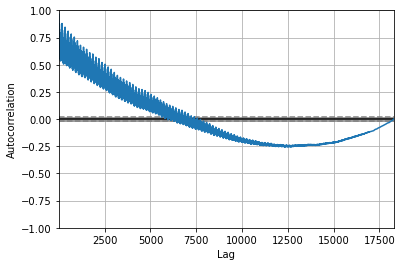

In [23]:
autocorrelation_plot(train_df['Count'])

In [188]:
delay = 24
X = []
Y = []
for i in range(len(train_df)-delay):
    current = train_df['Count'][i:i+delay].values
    X.append(current)
    Y.append(train_df['Count'][i+delay])
X = np.array(X)
Y = np.array(Y)
X = X.reshape((len(X),delay,1))
print(X.shape,Y.shape)

(18264, 24, 1) (18264,)


In [189]:
X[-3:]

array([[[936],
        [848],
        [942],
        [686],
        [546],
        [550],
        [416],
        [344],
        [334],
        [416],
        [498],
        [482],
        [512],
        [724],
        [656],
        [672],
        [642],
        [616],
        [686],
        [654],
        [622],
        [680],
        [868],
        [732]],

       [[848],
        [942],
        [686],
        [546],
        [550],
        [416],
        [344],
        [334],
        [416],
        [498],
        [482],
        [512],
        [724],
        [656],
        [672],
        [642],
        [616],
        [686],
        [654],
        [622],
        [680],
        [868],
        [732],
        [702]],

       [[942],
        [686],
        [546],
        [550],
        [416],
        [344],
        [334],
        [416],
        [498],
        [482],
        [512],
        [724],
        [656],
        [672],
        [642],
        [616],
        [686],
        [654],
      

In [190]:
Y[-3:]

array([702, 580, 534], dtype=int64)

In [191]:
X_train,X_test = X[0:17000],X[17000:]
Y_train,Y_test = Y[0:17000],Y[17000:]
print(X_train.shape,X_test.shape,Y_train.shape,Y_test.shape)

(17000, 24, 1) (1264, 24, 1) (17000,) (1264,)


In [58]:
from tensorflow.keras import layers, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [71]:
from tensorflow.keras.metrics import RootMeanSquaredError

In [192]:
callbackslist = [
    EarlyStopping(monitor='loss',patience=5),
    ModelCheckpoint(monitor='val_root_mean_squared_error',save_best_only=True,filepath='my_model.h5')
]

In [193]:
inputs = Input(shape=(delay,1),dtype='float32')
x = layers.LSTM(50,dropout=0.2,recurrent_dropout=0.5,return_sequences=True)(inputs)
x = layers.LSTM(50,dropout=0.2,recurrent_dropout=0.5)(x)
x = layers.Dense(32,activation='relu')(x)
outputs = layers.Dense(1)(x)
model = Model(inputs,outputs)
model.compile(optimizer='rmsprop',loss='mse',metrics=[RootMeanSquaredError()])
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 24, 1)]           0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 24, 50)            10400     
_________________________________________________________________
lstm_13 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_12 (Dense)             (None, 32)                1632      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 33        
Total params: 32,265
Trainable params: 32,265
Non-trainable params: 0
_________________________________________________________________


In [194]:
H = model.fit(X_train,Y_train,epochs=20,batch_size=128,validation_data=(X_test,Y_test),callbacks=callbackslist)

Train on 17000 samples, validate on 1264 samples
Epoch 1/20
17000/17000 [==============================] - 19s 1ms/sample - loss: 23840.7034 - root_mean_squared_error: 154.4043 - val_loss: 190772.3896 - val_root_mean_squared_error: 436.7750
Epoch 2/20
17000/17000 [==============================] - 12s 717us/sample - loss: 15228.6533 - root_mean_squared_error: 123.4044 - val_loss: 141000.3813 - val_root_mean_squared_error: 375.5002
Epoch 3/20
17000/17000 [==============================] - 12s 705us/sample - loss: 7894.5200 - root_mean_squared_error: 88.8511 - val_loss: 91149.6596 - val_root_mean_squared_error: 301.9100
Epoch 4/20
17000/17000 [==============================] - 12s 703us/sample - loss: 4031.5116 - root_mean_squared_error: 63.4942 - val_loss: 55823.8277 - val_root_mean_squared_error: 236.2707
Epoch 5/20
17000/17000 [==============================] - 12s 706us/sample - loss: 2544.9681 - root_mean_squared_error: 50.4477 - val_loss: 36786.4811 - val_root_mean_squared_error: 1

In [96]:
Y_train_pred = model.predict(X_train).astype('int')

In [80]:
Y_train_pred = scaler.inverse_transform(Y_train_pred)

In [82]:
Y_train_pred = Y_train_pred.astype('int')

In [97]:
Y_train_pred[:10]

array([[4],
       [4],
       [5],
       [4],
       [4],
       [5],
       [4],
       [4],
       [4],
       [3]])

In [84]:
scaler.inverse_transform(Y[:,np.newaxis])[:10]

array([[4.],
       [6.],
       [2.],
       [4.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [4.]])

In [98]:
Y[:,np.newaxis][:10]

array([[2],
       [6],
       [4],
       [2],
       [6],
       [2],
       [2],
       [2],
       [2],
       [2]], dtype=int64)

In [195]:
model.load_weights('my_model.h5')

In [196]:
model.evaluate(X_test,Y_test)

1264/1264 [==============================] - 1s 540us/sample - loss: 20052.9384 - root_mean_squared_error: 141.6084


[20052.938377670096, 141.6084]

In [197]:
test_df = pd.read_csv('Test.csv')
test_df.head()

,ID,Datetime
0,18288,26-09-2014 00:00
1,18289,26-09-2014 01:00
2,18290,26-09-2014 02:00
3,18291,26-09-2014 03:00
4,18292,26-09-2014 04:00


In [157]:
test_df.set_index(['ID'],inplace=True)
test_df['Datetime'] = pd.to_datetime(test_df['Datetime'])
test_df.head()

,Datetime
ID,
18288,2014-09-26 00:00:00
18289,2014-09-26 01:00:00
18290,2014-09-26 02:00:00
18291,2014-09-26 03:00:00
18292,2014-09-26 04:00:00


In [158]:
len(test_df)

5112

In [113]:
train_df.iloc[-10:,:]

,Datetime,Count,Count scaled
ID,,,
18278,2014-09-25 14:00:00,616,0.494364
18279,2014-09-25 15:00:00,686,0.550725
18280,2014-09-25 16:00:00,654,0.524960
18281,2014-09-25 17:00:00,622,0.499195
18282,2014-09-25 18:00:00,680,0.545894
18283,2014-09-25 19:00:00,868,0.697262
18284,2014-09-25 20:00:00,732,0.587762
18285,2014-09-25 21:00:00,702,0.563607
18286,2014-09-25 22:00:00,580,0.465378


In [159]:
curr_testinp = train_df.iloc[-delay:,1].values

In [160]:
curr_testinp_f = curr_testinp.reshape(delay,1)[np.newaxis,:,:]
curr_testinp_f.shape

(1, 10, 1)

In [161]:
curr_testinp.shape

(10,)

In [162]:
a = int(model.predict(curr_testinp_f)[0])

In [163]:
print(a)

501


In [198]:
curr_testinp = train_df.iloc[-delay:,1].values
Y_pred_test = np.zeros(len(test_df))
for i in range(len(test_df)):
    curr_testinp_f = curr_testinp.reshape(delay,1)[np.newaxis,:,:]
    val = model.predict(curr_testinp_f)[0]
    Y_pred_test[i] = val
    curr_testinp = np.append(curr_testinp,val)
    curr_testinp = curr_testinp[1:]
test_df['Count'] = Y_pred_test

In [147]:
a= np.array([1,2,3])
b = np.append(a,4)

print(b[1:])

[2 3 4]


In [200]:
test_df_new = test_df.drop(['Datetime'],axis=1)
#test_df_new = test_df_new.reset_index()
test_df_new['Count'] = test_df_new['Count'].astype('int32')
test_df_new.head(-5)

,ID,Count
0,18288,469
1,18289,410
2,18290,335
3,18291,256
4,18292,198
...,...,...
5102,23390,8
5103,23391,8
5104,23392,8
5105,23393,8


In [204]:
test_df.head()

,ID,Datetime,Count
0,18288,26-09-2014 00:00,469.193176
1,18289,26-09-2014 01:00,410.814056
2,18290,26-09-2014 02:00,335.822205
3,18291,26-09-2014 03:00,256.023743
4,18292,26-09-2014 04:00,198.897171


In [170]:
test_ID = test_df.index.values

In [171]:
test_df_new['ID'] = test_ID
test_df_new.head()

,Count,ID
ID,,
18288,501.0,18288
18289,477.0,18289
18290,451.0,18290
18291,420.0,18291
18292,380.0,18292


In [173]:
a = test_df.reset_index()
a.head()

,ID,Datetime,Count
0,18288,2014-09-26 00:00:00,501.0
1,18289,2014-09-26 01:00:00,477.0
2,18290,2014-09-26 02:00:00,451.0
3,18291,2014-09-26 03:00:00,420.0
4,18292,2014-09-26 04:00:00,380.0


In [201]:
pd.DataFrame(test_df_new).to_csv('submission_LSTM_24.csv',columns=['ID','Count'],index=None)

In [187]:
train_df.iloc[5000:5200,1]

ID
5000     6
5001    34
5002    26
5003    50
5004    58
        ..
5195    36
5196    28
5197    44
5198    28
5199    64
Name: Count, Length: 200, dtype: int64

In [182]:
b = np.array([[[511.70193],
       [516.3882 ],
       [515.901  ],
       [515.5572 ],
       [527.08105],
       [527.1812 ],
       [525.1306 ],
       [531.2548 ],
       [537.7709 ],
       [536.5806 ]]])
b.shape
#a = model.predict(X_test)

(1, 10, 1)

In [184]:
b.reshape(-1)

array([511.70193, 516.3882 , 515.901  , 515.5572 , 527.08105, 527.1812 ,
       525.1306 , 531.2548 , 537.7709 , 536.5806 ])

In [185]:
for i in range(20):
    a = model.predict(b)[0]
    print(a)
    b = b.reshape(-1)
    b = np.append(b,a)
    b = b[1:]
    b = b.reshape(1,10,1)

[480.2874]
[439.30106]
[394.18002]
[342.6565]
[288.6299]
[240.19456]
[195.69289]
[154.1571]
[124.032036]
[106.44247]
[98.415565]
[95.554756]
[95.14534]
[95.64601]
[95.977646]
[95.395874]
[93.36584]
[89.64581]
[84.747856]
[79.56478]


In [203]:
plt.style.use('dark_background')

In [207]:
train_df.head(-5)

,Datetime,Count,Count scaled
ID,,,
0,2012-08-25 00:00:00,8,0.004831
1,2012-08-25 01:00:00,2,0.000000
2,2012-08-25 02:00:00,6,0.003221
3,2012-08-25 03:00:00,2,0.000000
4,2012-08-25 04:00:00,2,0.000000
...,...,...,...
18278,2014-09-25 14:00:00,616,0.494364
18279,2014-09-25 15:00:00,686,0.550725
18280,2014-09-25 16:00:00,654,0.524960


In [206]:
test_df.head()

,ID,Datetime,Count
0,18288,26-09-2014 00:00,469.193176
1,18289,26-09-2014 01:00,410.814056
2,18290,26-09-2014 02:00,335.822205
3,18291,26-09-2014 03:00,256.023743
4,18292,26-09-2014 04:00,198.897171


In [208]:
a = []
d = []
for i in range(0,len(train_df),100):
    a.append(train_df['Count'][i])
    d.append(train_df['Datetime'][i])
for i in range(0,len(test_df),100):
    a.append(test_df['Count'][i])
    d.append(test_df['Datetime'][i])

In [209]:
len(a)

235

In [224]:
year = d[0:len(d):50]

In [225]:
year = [str(x) for x in year]
year = [x.split()[0] for x in year]
print(year)

['2012-08-25', '2013-03-21', '2013-10-15', '2014-12-05', '05-12-2014']


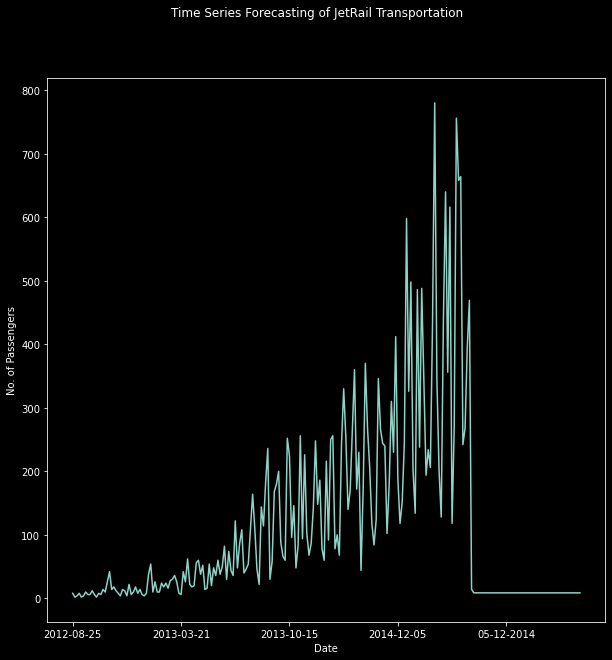

In [228]:
plt.figure(figsize=(10,10))
plt.plot(a)
plt.xlabel('Date')
plt.ylabel('No. of Passengers')
plt.xticks(ticks=range(0,len(d),50),labels=year,rotation='horizontal')
plt.suptitle('Time Series Forecasting of JetRail Transportation')
plt.show()